# E-mail Classification NLP

In [171]:
# https://www.kaggle.com/datasets/datatattle/email-classification-nlp

In [172]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator


In [173]:
train = pd.read_csv('SMS_train.csv',encoding='cp1252')
test = pd.read_csv('SMS_test.csv',encoding='cp1252')

In [174]:
df = pd.concat([train,test])

In [175]:
df.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


# EDA

<AxesSubplot:xlabel='Label', ylabel='count'>

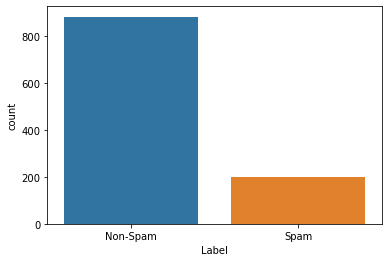

In [176]:
sns.countplot(x="Label", data = df)

In [177]:
print('Proportion of Non-Spam and Spam reviews: ')
print(df.Label.value_counts() / len(df))

Proportion of Non-Spam and Spam reviews: 
Non-Spam    0.817006
Spam        0.182994
Name: Label, dtype: float64


In [178]:
# Maping target value
df['Label']=df['Label'].map({'Non-Spam':0,'Spam':1})

In [179]:
#Remove special characters in Message_Body,digits,www
df['Message_body'] = df['Message_body'].str.replace("[^a-zA-Z0-9]", " ")

df['Message_body']= df['Message_body'].str.replace(' \d+ ','')

df['Message_body'] = df['Message_body'].str.replace('www','')

In [180]:
word_tokens = [word_tokenize(mesaage) for mesaage in df.Message_body]
print(word_tokens[0])

len_tokens = []

for i in range(len(word_tokens)):
     len_tokens.append(len(word_tokens[i]))

df['n_words'] = len_tokens 
df.head()

['Rofl', 'Its', 'true', 'to', 'its', 'name']


,S. No.,Message_body,Label,n_words
0,1,Rofl Its true to its name,0,6
1,2,The guy did some bitching but I acted like i d...,0,27
2,3,Pity was in mood for that So any other s...,0,10
3,4,Will b going to esplanade fr home,0,7
4,5,This is the 2nd time we have triedcontact u U...,1,26


In [181]:
df.groupby(by=["Label"], dropna=False).mean()

,S. No.,n_words
Label,,
0,456.314480,14.084842
1,317.656566,21.858586


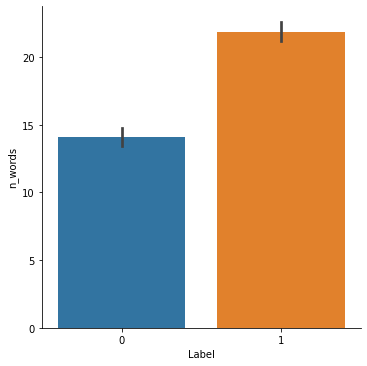

In [182]:
sns.catplot(x="Label", y="n_words", kind="bar", data=df);

# Wordcloud

In [183]:
from nltk.corpus import stopwords
import nltk


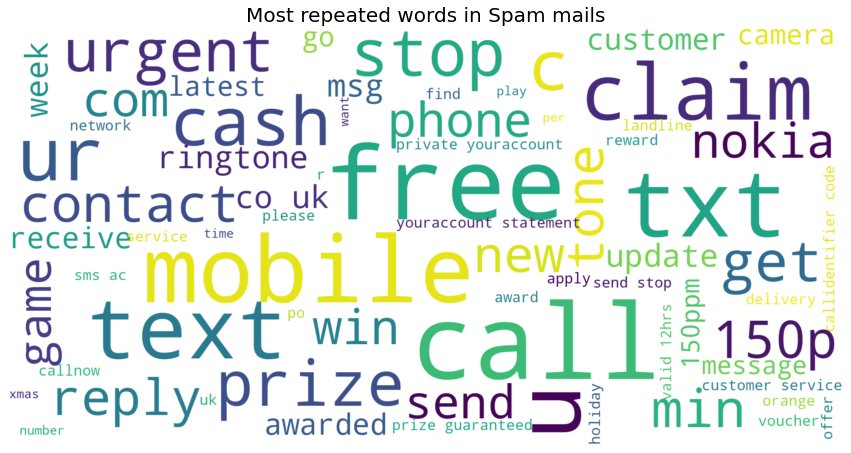

In [184]:
message_body_spam = ",".join(spam_mail.lower() for spam_mail in df.Message_body[df.Label == 1])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

# Display the generated image:
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in Spam mails',fontsize=20)
plt.show()

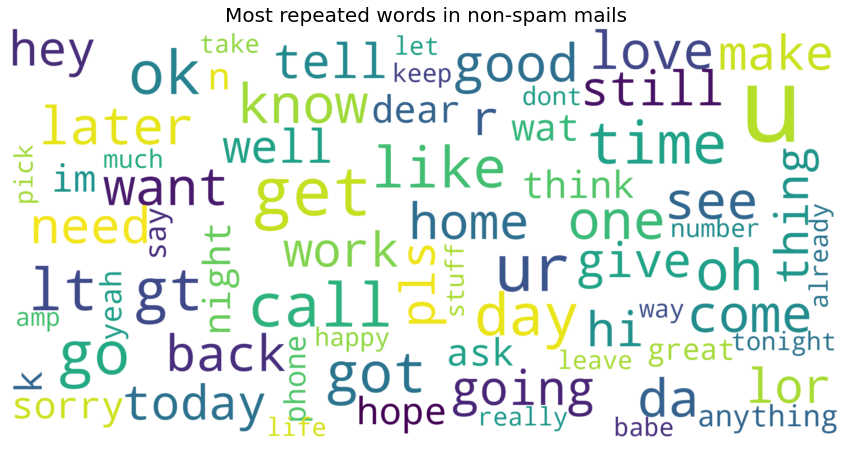

In [185]:
message_body_not_spam = ",".join(spam_mail.lower() for spam_mail in df.Message_body[df.Label == 0])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=70, 
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_not_spam)

# Display the generated image:
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in non-spam mails',fontsize=20)
plt.show()

# Model

In [186]:
y = df.Label
X=df['Message_body']

splitter = StratifiedKFold(n_splits=5,shuffle=True,random_state =42)
for train,test in splitter.split(X,y):    
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
print(y_train.value_counts())  
print(y_test.value_counts())



# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)


0    708
1    158
Name: Label, dtype: int64
0    176
1     40
Name: Label, dtype: int64


In [187]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the last 10 features
print(tfidf_vectorizer.get_feature_names_out()[:-10])

# Print the last 5 vectors of the tfidf training data
print(tfidf_train.A[:-5])

['000' '04' '0776xxxxxxx' ... 'yijue' 'yo' 'yoga']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [188]:
# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names_out())

# Print the head of tfidf_df
print(tfidf_df.head())

   000   04  0776xxxxxxx  078  08000930705  08002986030  08002986906  \
0  0.0  0.0          0.0  0.0          0.0          0.0          0.0   
1  0.0  0.0          0.0  0.0          0.0          0.0          0.0   
2  0.0  0.0          0.0  0.0          0.0          0.0          0.0   
3  0.0  0.0          0.0  0.0          0.0          0.0          0.0   
4  0.0  0.0          0.0  0.0          0.0          0.0          0.0   

   08452810075over18  08700621170150p  08701417012150p  ...  yor  youdoing  \
0                0.0              0.0              0.0  ...  0.0       0.0   
1                0.0              0.0              0.0  ...  0.0       0.0   
2                0.0              0.0              0.0  ...  0.0       0.0   
3                0.0              0.0              0.0  ...  0.0       0.0   
4                0.0              0.0              0.0  ...  0.0       0.0   

   young  younger  youraccount   yr  yummy  yup  zedprofitcharity  zeros  
0    0.0      0.0      

In [189]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])


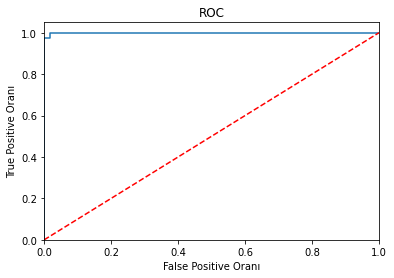

AUC : 0.8375
--------------------------------
Accuracy_score:  0.9398148148148148
--------------------------------
Confusion matrix: 
[[176   0]
 [ 13  27]]
--------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       176
           1       1.00      0.68      0.81        40

    accuracy                           0.94       216
   macro avg       0.97      0.84      0.89       216
weighted avg       0.94      0.94      0.94       216



In [190]:

logit_roc_auc =  roc_auc_score(y_test, pred)
            
fpr, tpr, thresholds = roc_curve(y_test, nb_classifier.predict_proba(count_test)[:,1])
            
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()


  
print("AUC :", logit_roc_auc)
print('--------------------------------')
print('Accuracy_score: ',score)
print('--------------------------------')
print('Confusion matrix: ')
print(cm)
print('--------------------------------')
print(classification_report(y_test,pred))
    